#### 확률론적 언어 모형의 활용
- 철자 및 문법 교정(Spell Correction)
- 음성 인식 (Speech Recognition)
- 자동 번영 (Machine Translation)
- 자동 요약 (Summarization)
- 챗봇 (Question-Answering)

#### N-그램 조건부 확률
- 문맥을 이루는 단어의 수가 많으면 조건부 확률의 개수가 너무 많아짐
- 현실적으로 조건부 확률을 계산 및 저장할 수 없음
- 따라서 다음과 같은 간략화 모형을 주로 사용
    - 유니그램 모형 (Unigram Model)
    - 바이그램 모형 (Bigram Model) = 마코브 모형 (Markov Model)

#### NLTK 패키지의 바이그램 모형
- ngram 명령으로 문장을 바이그램 분해
- ConditionalFreqDist 클래스로 각 문맥별 단어 빈도를 측정
- ConditionalProbDist 클래스로 조건부 확률을 추정

##### step 1. 말뭉치 바이어그램 토큰화

In [2]:
from nltk.corpus import movie_reviews
from nltk.util import ngrams

sentences = []
for tokens in movie_reviews.sents():
    bigram = ngrams(tokens, 2, pad_left=True, pad_right=True, left_pad_symbol="SS", right_pad_symbol="SE")
    sentences += [t for t in bigram]
sentences[:17]

[('SS', 'plot'),
 ('plot', ':'),
 (':', 'two'),
 ('two', 'teen'),
 ('teen', 'couples'),
 ('couples', 'go'),
 ('go', 'to'),
 ('to', 'a'),
 ('a', 'church'),
 ('church', 'party'),
 ('party', ','),
 (',', 'drink'),
 ('drink', 'and'),
 ('and', 'then'),
 ('then', 'drive'),
 ('drive', '.'),
 ('.', 'SE')]

##### step 2. ConditionalFreqDist 클래스 객체 생성

In [3]:
from nltk import ConditionalFreqDist

cfd = ConditionalFreqDist(sentences)

In [8]:
# 문장의 처음에 올 수 있는 단어들
cfd['SS'].most_common(5)

[('the', 8071), ('.', 3173), ('it', 3136), ('i', 2471), ('but', 1814)]

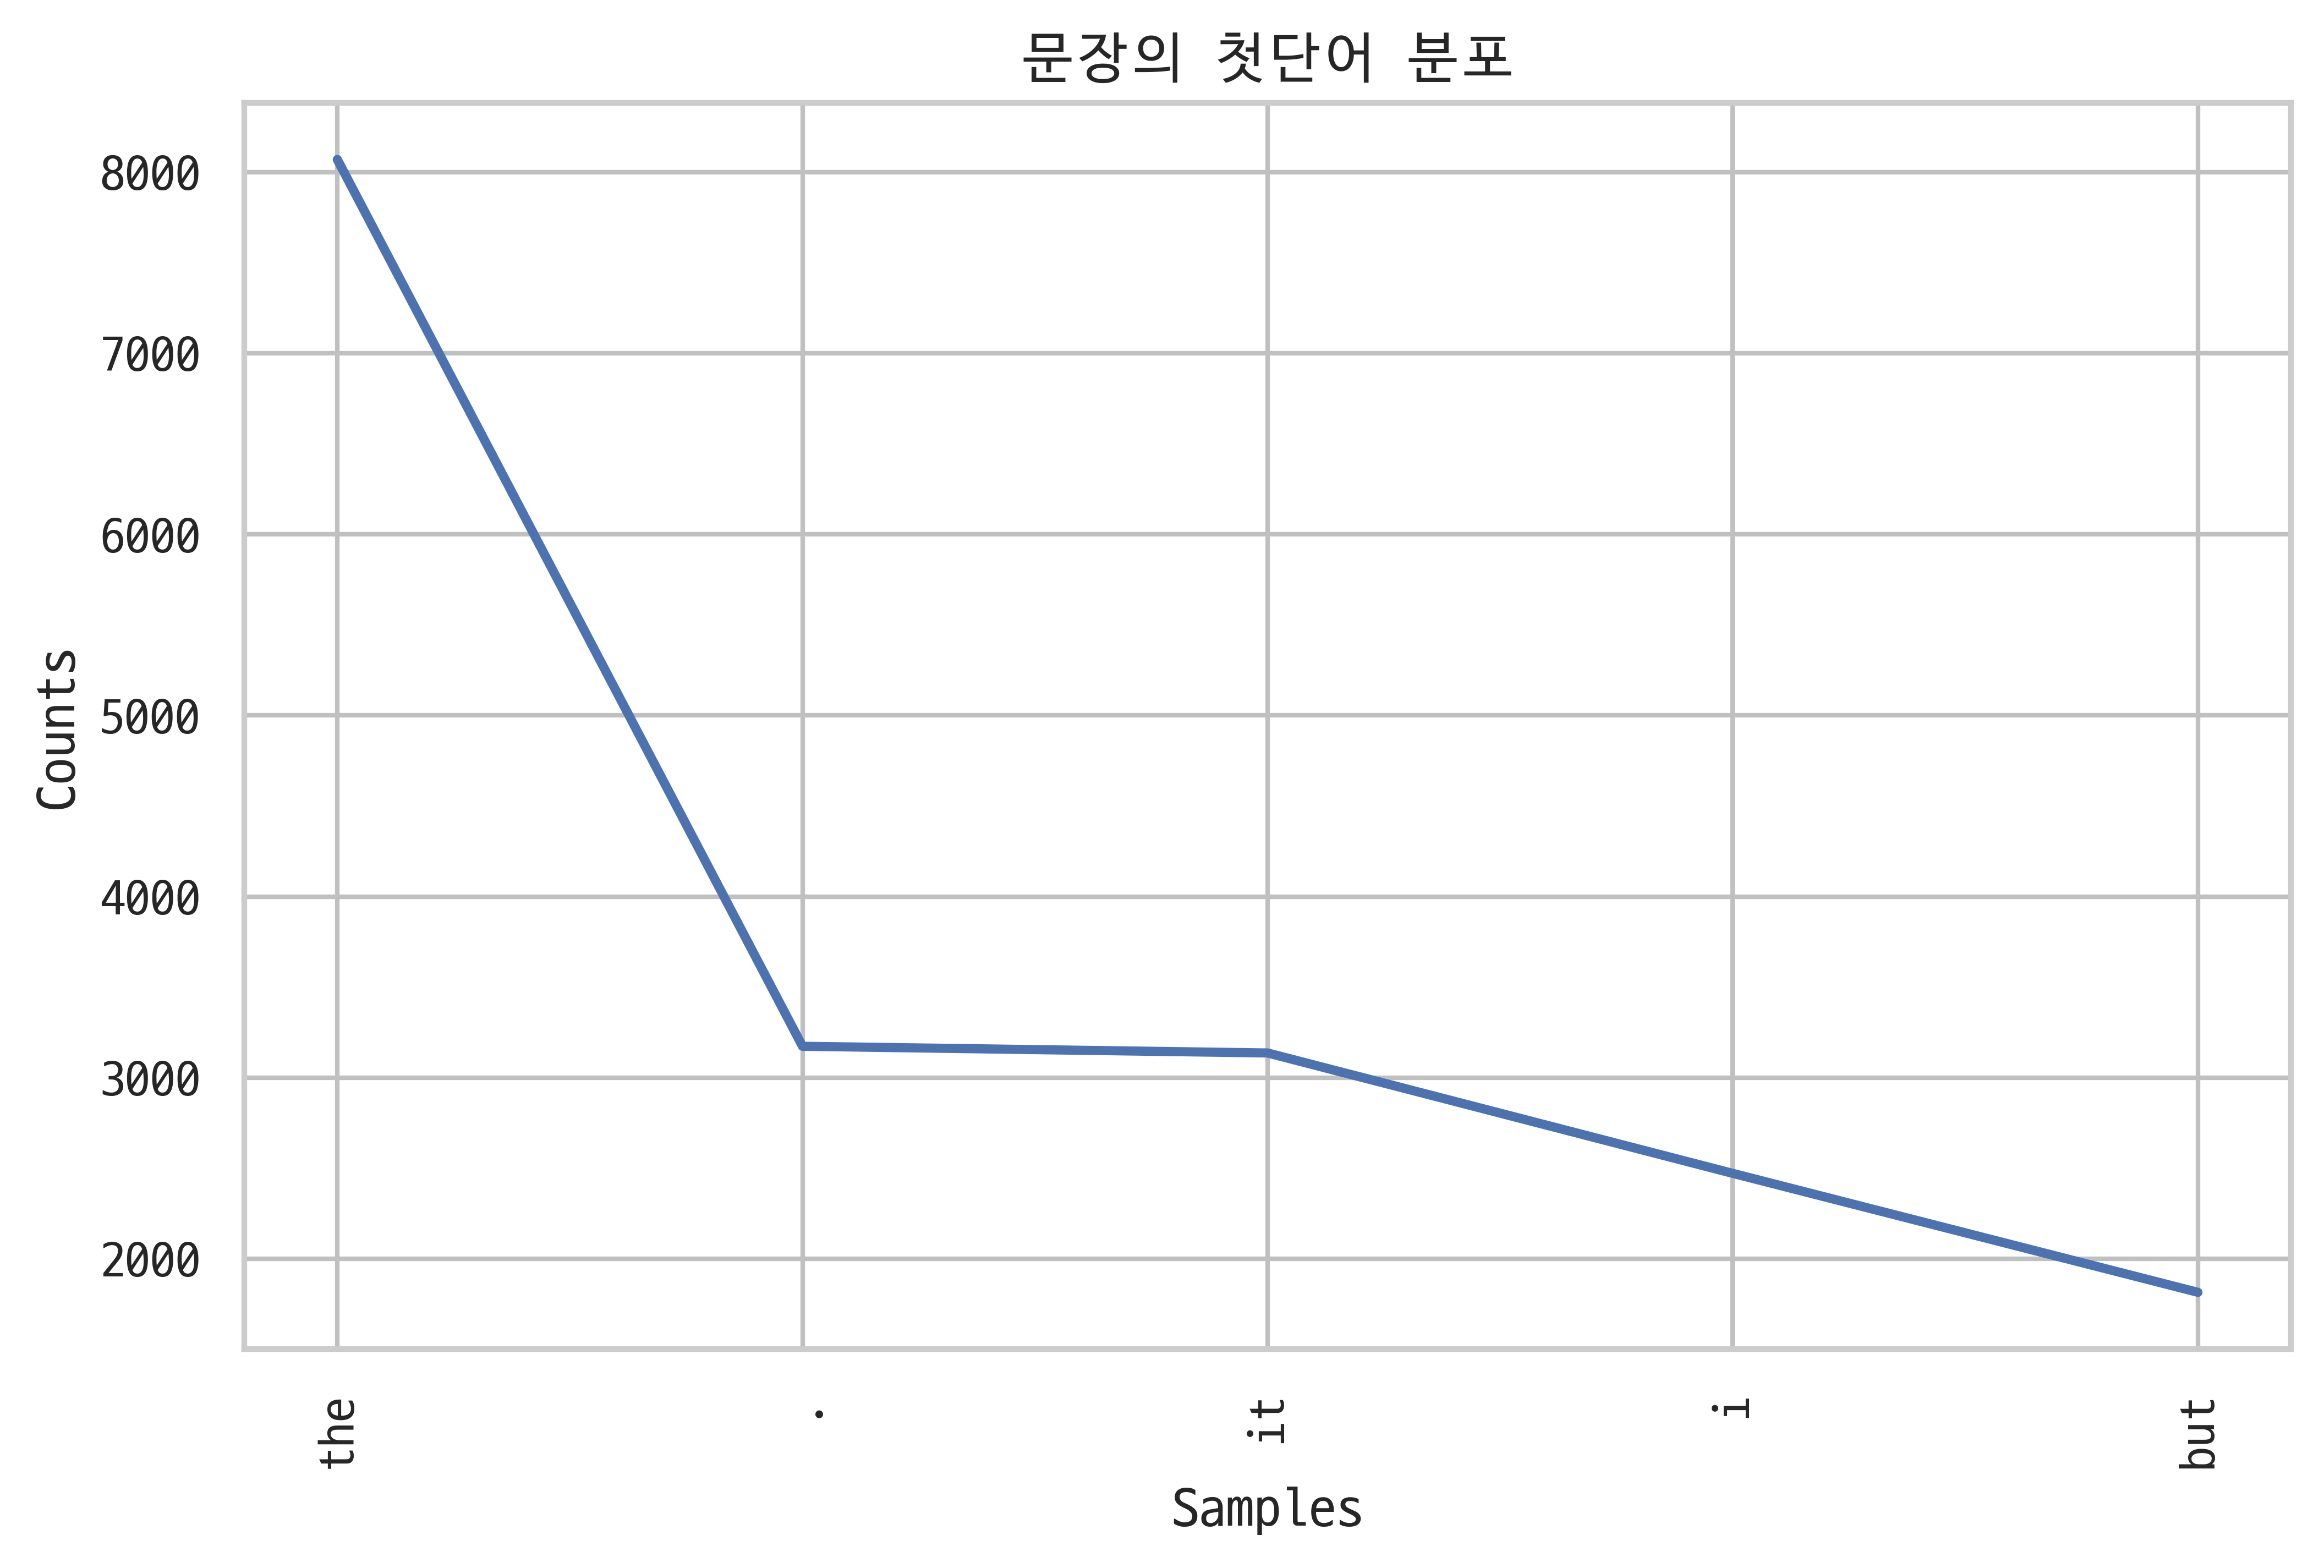

In [9]:
cfd['SS'].plot(5, title='문장의 첫단어 분포')
plt.show()

In [10]:
# i 다음에 올 수 있는 단어들
cfd['i'].most_common(5)

[("'", 1357), ('was', 506), ('can', 351), ('have', 330), ('don', 276)]

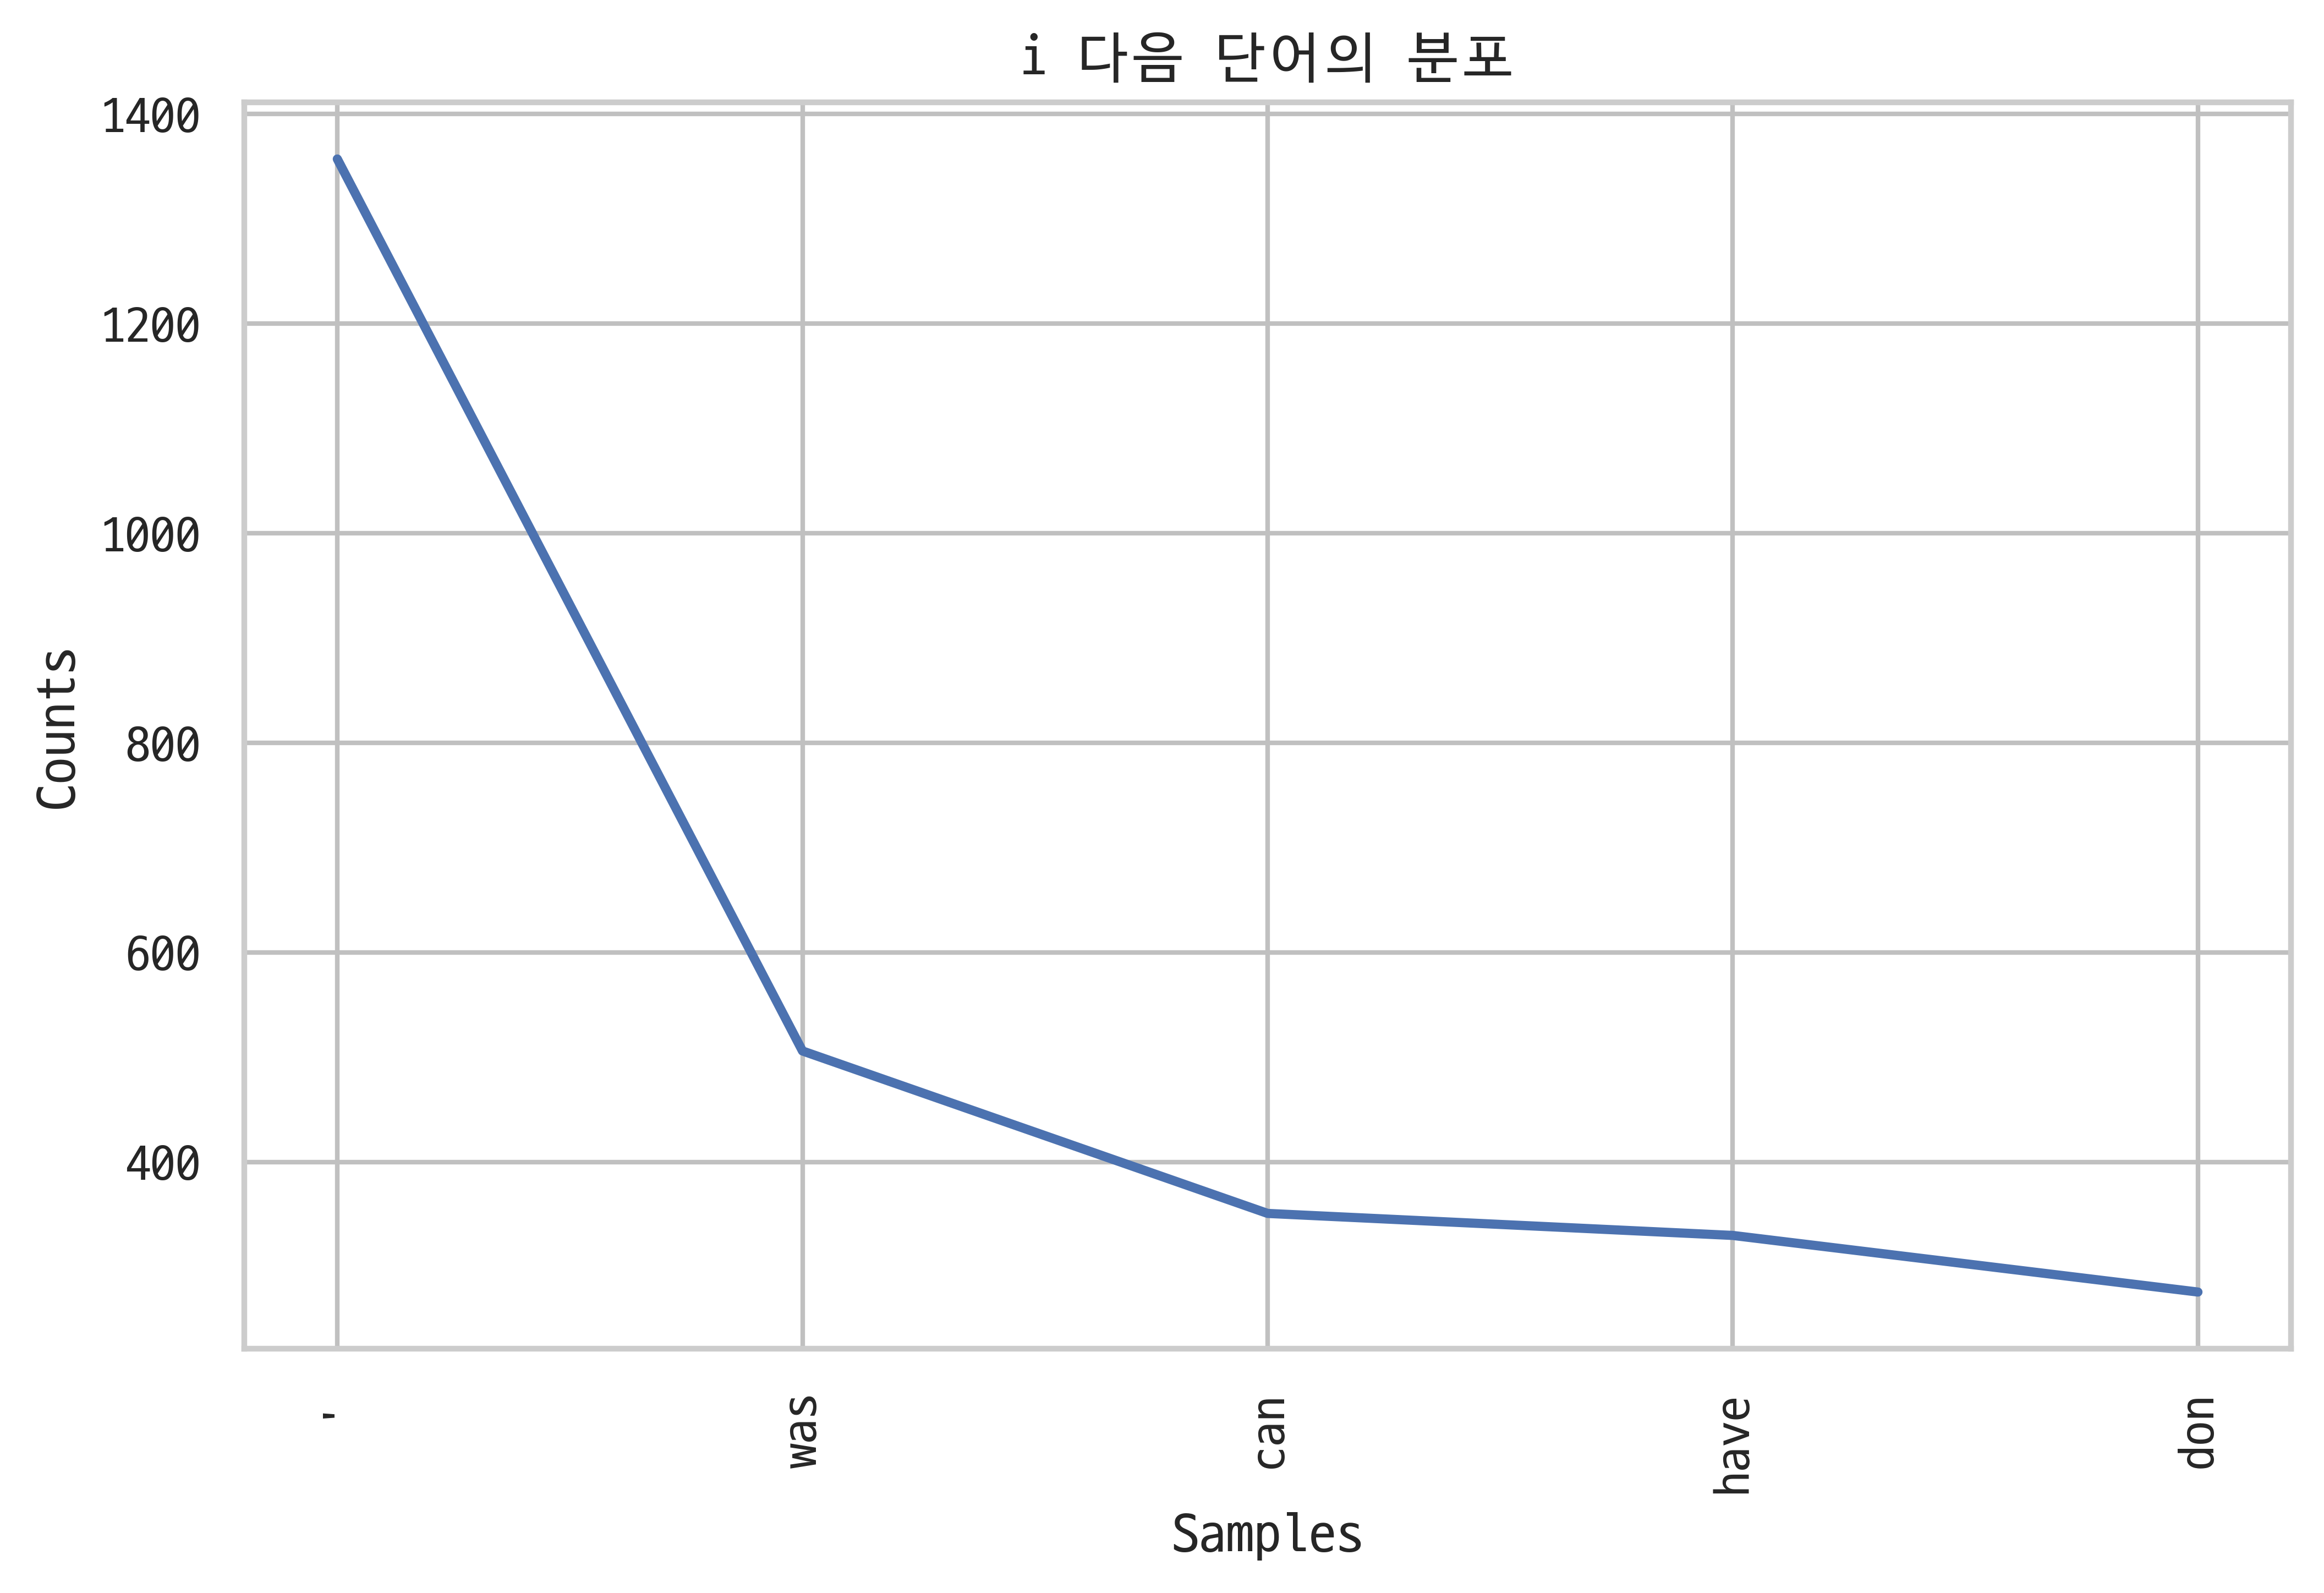

In [12]:
cfd['i'].plot(5, title='i 다음 단어의 분포')
plt.show()

In [13]:
# 마침표 다음에 올 수 있는 단어들
cfd['.'].most_common(5)

[('SE', 63404), ('"', 1854), (')', 535), ("'", 70), (']', 10)]

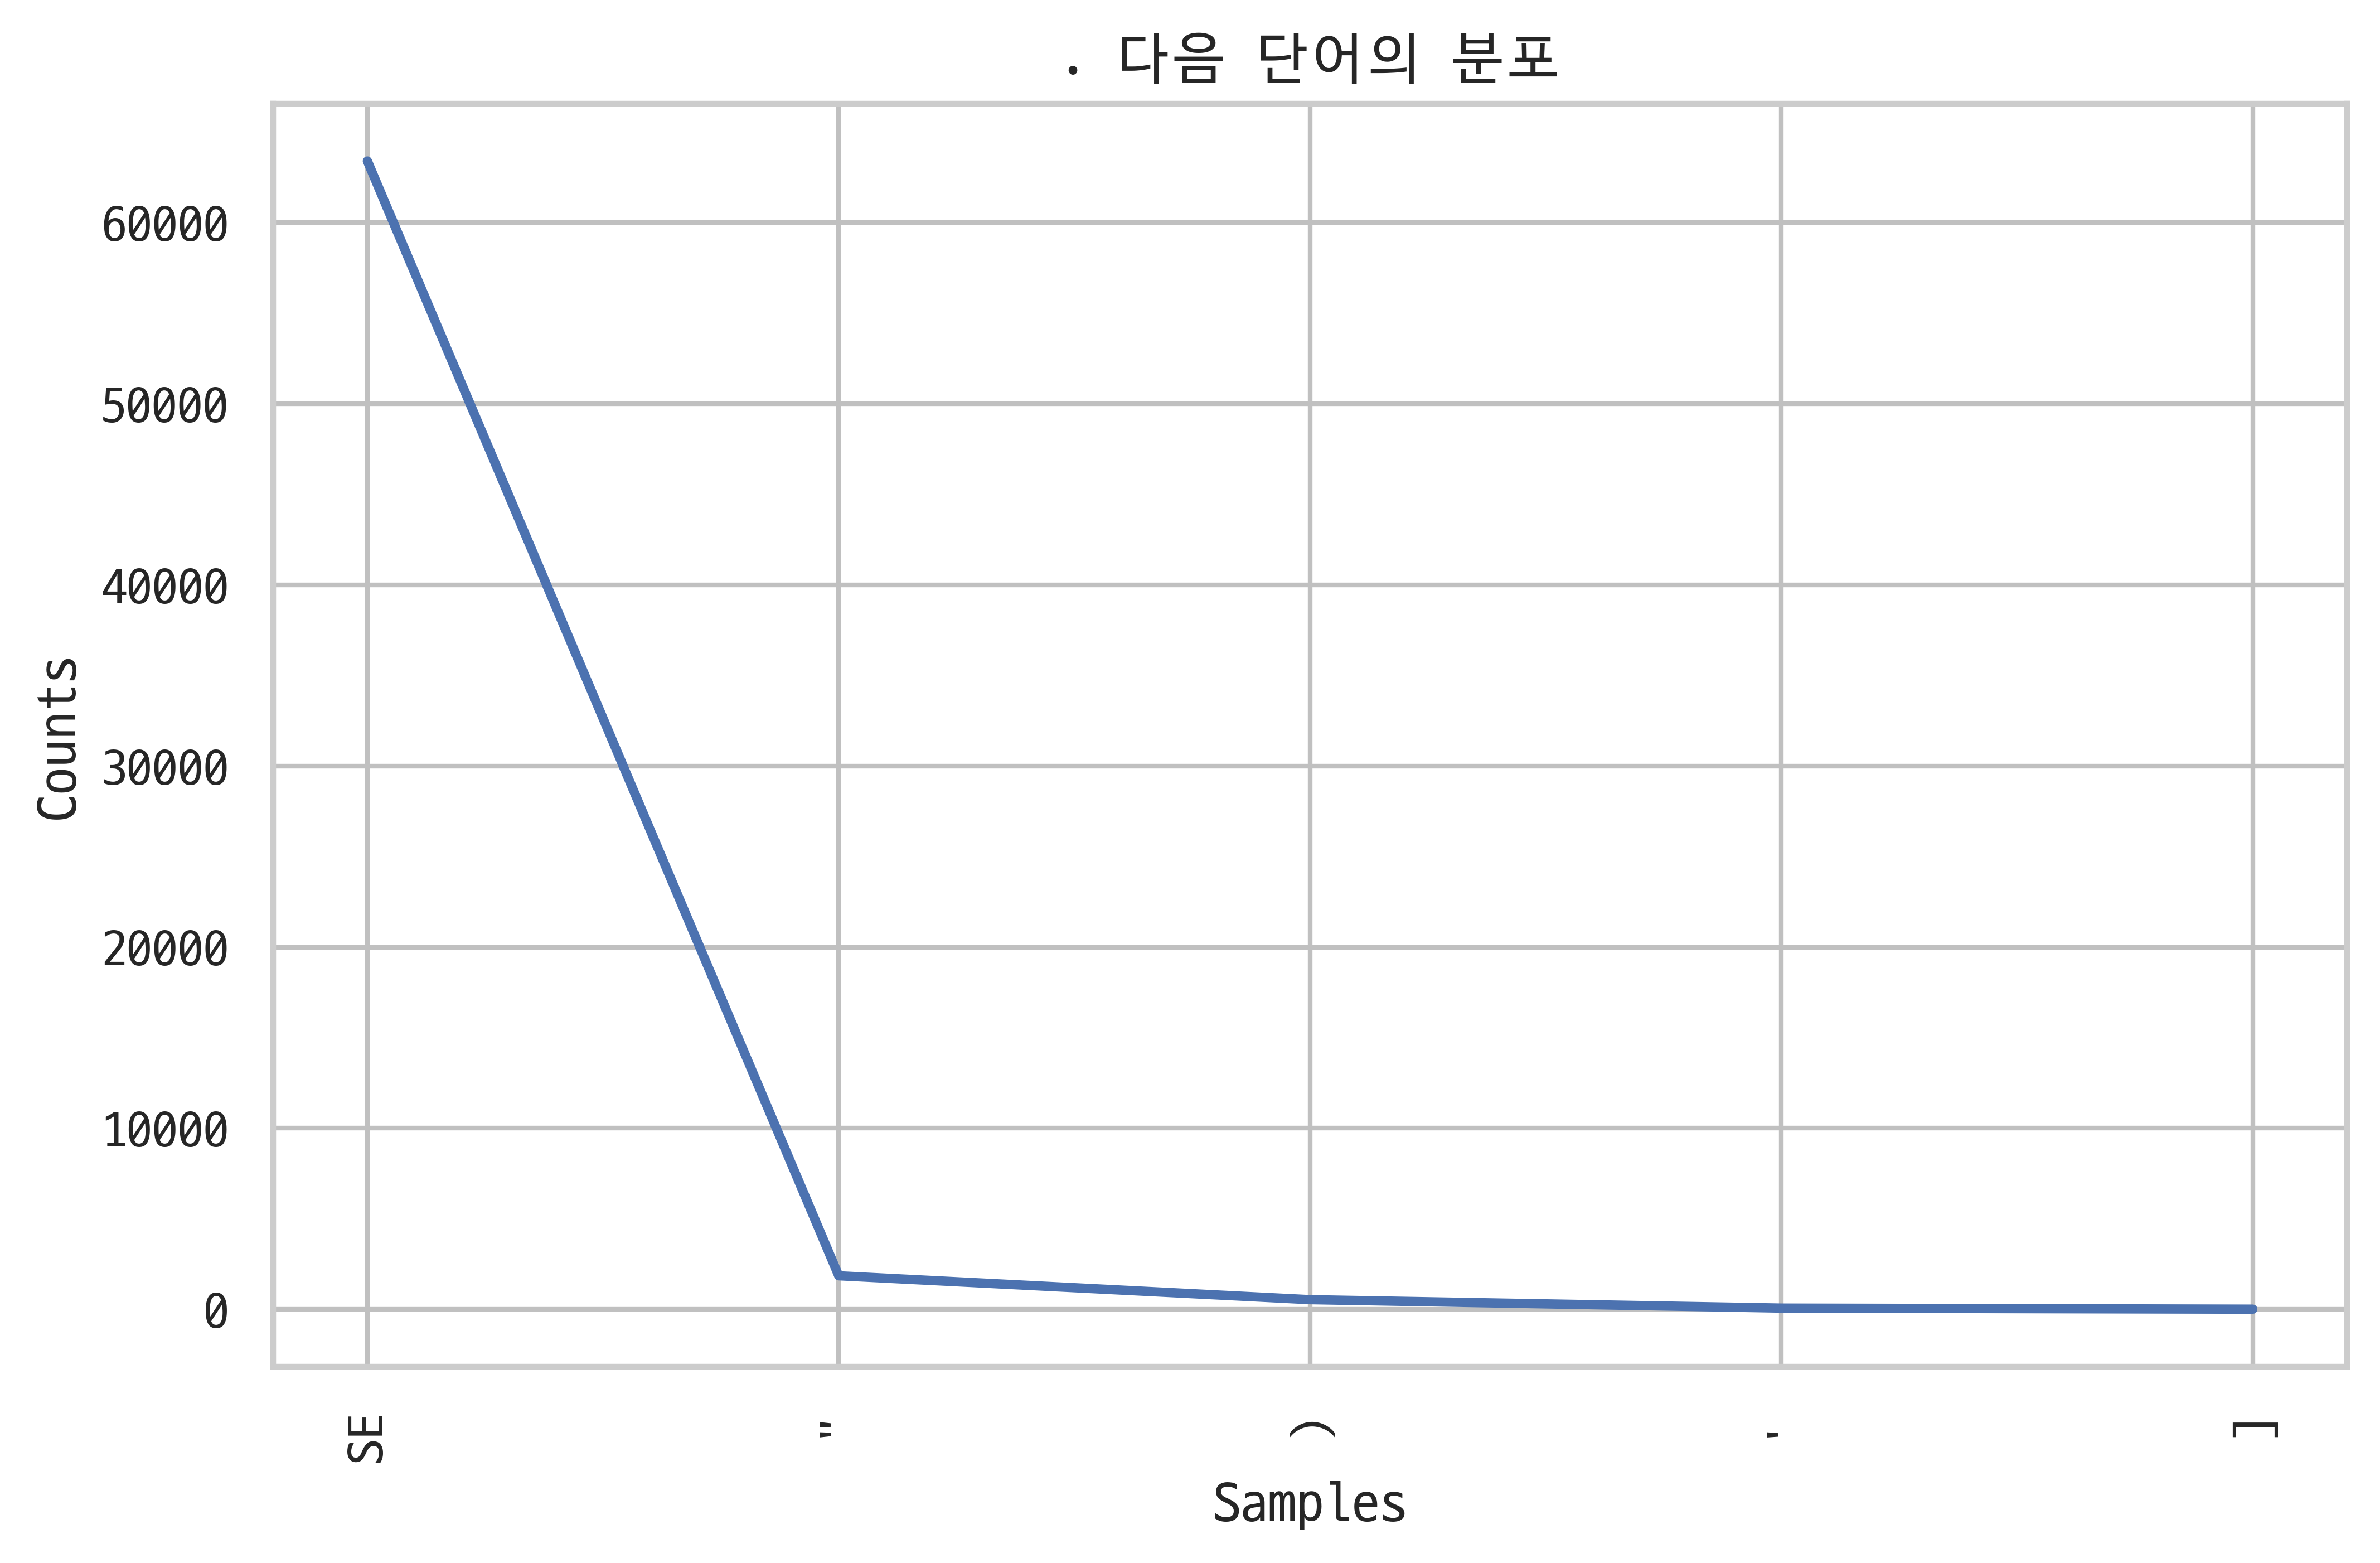

In [14]:
cfd['.'].plot(5, title='. 다음 단어의 분포')
plt.show()

##### step 3. 조건부 확률 추정

In [15]:
from nltk.probability import ConditionalProbDist, MLEProbDist

cpd = ConditionalProbDist(cfd, MLEProbDist)

In [16]:
cpd['i'].prob('am')

0.018562267971650354

In [17]:
cpd['i'].prob('is')

0.0002249971875351558

In [18]:
cpd['we'].prob('are')

0.08504504504504505

In [19]:
cpd['we'].prob('is')

0.0

##### step 4. 문장 확률 계산 (바이그램 언어 모형)

In [22]:
def sentence_score(s):
    p  = 0.0
    for i in range(len(s) - 1):
        c = s[i]
        w = s[i + 1]
        p += np.log(cpd[c].prob(w) + np.finfo(float).eps)
    return np.exp(p)

In [23]:
# 높은 확률이다 (100만개 문장 중에 이런 문장이 하나 있을 수 있다는 의미)
test_sentence = ['i', 'like', 'the', 'movie', '.']
sentence_score(test_sentence)

2.740764134071561e-06

In [24]:
# 낮은 확률이다
test_sentence = ['like', 'i', 'the', '.', 'movie']
sentence_score(test_sentence)

1.5015040140827832e-38

In [25]:
test_sentence1 = ['the', 'actors', 'are', 'amazing', '.']
test_sentence2 = ['the', '.', 'is', 'actors', 'amazing']
sentence_score(test_sentence1), sentence_score(test_sentence2)

(1.922688595934368e-08, 2.8610446373612017e-52)

##### step 5. 무작위 문장 생성

In [41]:
def generate_sentence(seed=None):
    if seed is not None:
        import random
        random.seed(seed)
    c = 'SS'
    sentence = []
    while True:
        if c not in cpd:
            break
        w = cpd[c].generate()
        
        if w == 'SE':
            break
        elif w in ['i', 'ii', 'iii']:
            w2 = w.upper()
        elif w in ['mr', 'luc', 'i', 'robin', 'williams', 'cindy', 'crawford']:
            w2 = w.title()
        else:
            w2 = w
            
        if c =='SS':
            sentence.append(w2.title())
        elif c in ['`', '\'', "'", '(']:
            sentence.append(w2)
        elif c in ["'", '.', ',', ')', ':', ';', '?']:
            sentence.append(w2)
        else:
            sentence.append(" " + w2)
        
        c = w
    return "".join(sentence)

In [42]:
generate_sentence(0)

"Granted that time ,a heartbeat ,the united states is instantly falls short ,in movie until producer matthew lillard seems woefully naive ,and emotional issues without unintentionally hilarious pirate 've got a gentle and paxton was really be frightened by his mastery of love that spencer exclaims one of a machine as a combination ."

In [45]:
generate_sentence(6)

"Writers in one of the prison ,yet ,works as agent ray liotta ,one of watching ,we supposed to doubt that the holocaust - or the fact ,the amc and don 's wonderful experience ,do what could either ."

#### 한글자료 활용

In [48]:
%%time
!wget -nc -q https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

Wall time: 7.76 s


In [49]:
import codecs
with codecs.open('ratings_train.txt', encoding='utf-8') as f:
    data = [line.split('\t') for line in f.read().splitlines()]
    data = data[1:]    # header 제외

docs = [row[1] for row in data]
len(docs)

150000

In [50]:
import warnings
warnings.simplefilter('ignore')

from konlpy.tag import Okt

tagger = Okt()

def tokenize(doc):
    tokens = ['/'.join(t) for t in tagger.pos(doc)]
    return tokens

tokenize('그 영화는 아주 재미있었어요.')

['그/Noun', '영화/Noun', '는/Josa', '아주/Noun', '재미있었어요/Adjective', './Punctuation']

In [51]:
from tqdm import tqdm
sentences = []
for d in tqdm(docs):
    tokens = tokenize(d)
    bigram = ngrams(tokens, 2, pad_left=True, pad_right=True, left_pad_symbol="SS", right_pad_symbol="SE")
    sentences += [t for t in bigram]

100%|██████████| 150000/150000 [14:50<00:00, 168.51it/s]


In [52]:
sentences[:30]

[('SS', '아/Exclamation'),
 ('아/Exclamation', '더빙/Noun'),
 ('더빙/Noun', '../Punctuation'),
 ('../Punctuation', '진짜/Noun'),
 ('진짜/Noun', '짜증나네요/Adjective'),
 ('짜증나네요/Adjective', '목소리/Noun'),
 ('목소리/Noun', 'SE'),
 ('SS', '흠/Noun'),
 ('흠/Noun', '.../Punctuation'),
 ('.../Punctuation', '포스터/Noun'),
 ('포스터/Noun', '보고/Noun'),
 ('보고/Noun', '초딩/Noun'),
 ('초딩/Noun', '영화/Noun'),
 ('영화/Noun', '줄/Noun'),
 ('줄/Noun', '..../Punctuation'),
 ('..../Punctuation', '오버/Noun'),
 ('오버/Noun', '연기/Noun'),
 ('연기/Noun', '조차/Josa'),
 ('조차/Josa', '가볍지/Adjective'),
 ('가볍지/Adjective', '않구나/Verb'),
 ('않구나/Verb', 'SE'),
 ('SS', '너/Modifier'),
 ('너/Modifier', '무재/Noun'),
 ('무재/Noun', '밓었/Noun'),
 ('밓었/Noun', '다그/Noun'),
 ('다그/Noun', '래서/Noun'),
 ('래서/Noun', '보는것을/Verb'),
 ('보는것을/Verb', '추천/Noun'),
 ('추천/Noun', '한/Josa'),
 ('한/Josa', '다/Adverb')]

In [53]:
cfd = ConditionalFreqDist(sentences)
cpd = ConditionalProbDist(cfd, MLEProbDist)

def korean_most_common(c, n, pos=None):
    if pos is None:
        return cfd[tokenize(c)[0]].most_common(n)
    else:
        return cfd['/'.join([c, pos])].most_common(n)

In [54]:
korean_most_common("나", 10)

[('는/Josa', 831),
 ('의/Josa', 339),
 ('만/Josa', 213),
 ('에게/Josa', 148),
 ('에겐/Josa', 84),
 ('랑/Josa', 81),
 ('한테/Josa', 50),
 ('참/Verb', 45),
 ('이/Determiner', 44),
 ('와도/Josa', 43)]

In [55]:
korean_most_common("의", 10)

[('영화/Noun', 19),
 ('연기/Noun', 14),
 ('구심/Noun', 12),
 ('모습/Noun', 9),
 ('감독/Noun', 8),
 ('매력/Noun', 7),
 ('감동/Noun', 7),
 ('흐름/Noun', 6),
 ('그/Noun', 6),
 ('이야기/Noun', 6)]

In [56]:
korean_most_common('.', 10, 'Punctuation')

[('SE', 26503),
 ('영화/Noun', 667),
 ('이/Noun', 565),
 ('정말/Noun', 480),
 ('그리고/Conjunction', 455),
 ('./Punctuation', 445),
 ('하지만/Conjunction', 369),
 ('이/Determiner', 352),
 ('그/Noun', 325),
 ('스토리/Noun', 317)]

In [59]:
def korean_bigram_prob(c, w):
    context = tokenize(c)[0]
    word = tokenize(w)[0]
    return cpd[context].prob(word)

In [60]:
korean_bigram_prob('이', '영화')

0.4010748656417948

In [61]:
korean_bigram_prob('영화', '이')

0.00015767585785521414

In [62]:
def korean_generate_sentence(seed=None, debug=False):
    if seed is not None:
        import random
        random.seed(seed)
    c = 'SS'
    sentence = []
    while True:
        if c not in cpd:
            break
        w = cpd[c].generate()
        
        if w == 'SE':
            break
        w2 = w.split('/')[0]
        pos = w.split('/')[1]
        
        if c =='SS':
            sentence.append(w2.title())
        elif c in ['`', '\'', "'", '(']:
            sentence.append(w2)
        elif w2 in ["'", '.', ',', ')', ':', ';', '?']:
            sentence.append(w2)
        elif pos in ['Josa', 'Punctuation', 'Suffix']:
            sentence.append(w2)
        elif w in ["임/Noun", "것/Noun", "는걸/Noun", "릴때/Noun", "되다/Verb", "이다/Verb", "하다/Verb", "이다/Adjective"]:
            sentence.append(w2)
        else:
            sentence.append(" " + w2) 
        c = w
        
        if debug:
            print(w)
            
    return "".join(sentence)

In [63]:
korean_generate_sentence(0)

'미키짱과 말도 전혀 빗나가지 않던 전개로 꽥꽥대는거 보니까 요^^'

In [64]:
korean_generate_sentence(1)

'내용 일테인데 이 영화 최고의 암살 할려고 한 데 선배랑 김선아 연기도 크다. 배슬기 여배우도 있는 척 하는거지?'

In [65]:
korean_generate_sentence(2)

'도리까지 본 영화 너무... 뭔가.. 최고네요. 하지만.. 눈물 낫다는건 또 영화에 들지 않는다. 근데 뭐야 어떻게 그렇게 착했던 윤재랑은 에바 그린 드레스 소리 듣는거임""" 에리 욧의 미모로 합성 한 가수 노래와 흥행 놓친 영화다. 사투리 연기 하나 없는 ‘ 스피드 감 넘치는 스릴 넘치는 연기를 이해 되지 못 하시는 분보다 훨 재밌구만 평점을 망처 놓은 듯하다. 영화 보는이로 하여금 불편함을 느꼇을듯'

In [66]:
korean_generate_sentence(3)

'내 인생을 반헬싱이 너무 무섭고 재밌고, 칼 세이건으로 연탄가스 맡아서 죽을 같이 작업 하는구나 ㅋㅋㅋㅋㅋ 진짜'

In [68]:
korean_generate_sentence(5)

'좋았어요... ㅎㄷㄷㄷ 시나리오나 그래픽이 대단한 심리전이 미라 파스틱 함.. 너무 무섭고 나쁜세 끼는 듯 진짜 꼭 필요가 있는지도 모르겠지만 나름 그의 복수 후!!!!!!!!!!!'